# Prevendo a Produção de Café

# Objetivo

Com as estatísticas retiradas do site da Organização Internacional do Café (ICO), que é a principal organização intergovernamental para o café, queremos prever a produção total do produto.

Dados retirados do site: <a href="https://www.ico.org/trade_statistics.asp?section=Statistics" target="_blank"> INTERNATIONAL COFFE ORGANIZATION - ICO </a>

As colunas do dataset são:
 
* disappearance.csv: Desaparecimento (consumo) em países importadores selecionados
* domestic_consumption.csv: Consumo doméstico de todos os países exportadores
* exports_calender-year.csv: Exportações de todas as formas de café de todos os países exportadores
* exports_crop_year.csv: Exportações totais de todos os países exportadores
* gross-opening_stocks.csv: Estoques iniciais brutos em todos os países exportadores
* imports.csv: Importações por países importadores selecionados
* indicator_prices.csv: preços indicativos de composição e de grupo da ICO
* inventories.csv: Estoques de café verde em países importadores selecionados
* prices_paid_to_growers.csv: Preços pagos aos produtores nos países exportadores
* re_exports.csv: Reexportação por países importadores selecionados
* retail_prices.csv: Preços de varejo do café torrado em países importadores selecionados
* total_production.csv: Produção total de todos os países exportadores 

## 1. Carregando os Dados

In [11]:
# Importando as bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


In [12]:
# Carregando os datasets
df1 = pd.read_csv('domestic-consumption.csv')
df2 = pd.read_csv('exports-calendar-year.csv')
df3 = pd.read_csv('exports-crop-year.csv')
df4 = pd.read_csv('gross-opening-stocks.csv')
df5 = pd.read_csv('total-production.csv')


In [13]:
# Visualizar as primeiras linhas do dataset
df1.head()

,domestic_consumption,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Angola,20.0,30.0,35.0,20.00,25.0,10.0,20.0,40.0,30.0,...,30.000,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0
1,Bolivia (Plurinational State of),25.0,27.0,27.5,28.50,29.5,30.5,31.5,32.5,33.0,...,46.000,47.5,49.0,50.5,52.0,53.5,55.0,57.0,58.5,60.0
2,Brazil,8200.0,8500.0,8900.0,9100.00,9300.0,10100.0,11000.0,11500.0,12200.0,...,18390.000,19132.0,19720.0,20330.0,20085.0,20333.0,20508.0,21225.0,21997.0,22250.0
3,Burundi,2.0,1.6,1.7,1.91,2.0,2.0,2.0,2.0,2.0,...,1.399,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,Ecuador,350.0,350.0,350.0,350.00,350.0,350.0,300.0,300.0,300.0,...,150.000,150.0,150.0,150.0,155.0,155.0,155.0,155.0,155.0,155.0


Os dados começam no ano de 1990 e terminam em 2018. Para que os dados antigos não interfiram numa previsão para anos mais recentes, vamos pegar apenas os últimos três anos (2016, 2017 e 2018) e  criar um novo dataset com a valores médios.

In [14]:
def year(dfs):
    
    ''' Seleciona os dados dos anos e 2016, 2017 e 2018, 
        cria um nodo dataset com os valores médios dos dados'''

    list_df = [] # lista vazia para adicionar os dados

    for df in dfs:
        country = df[df.columns[0]] # pega a coluna com os nomes dos países
        year = df[['2016','2017','2018']].mean(axis=1) # seleciona os anos e calcula os valores médios
        df = pd.concat([country, year], axis=1) # junta os dados dos ano com os respectivos países
        df.columns = ['Country', country.name] 

        list_df.append(df) # adiciona na lista  
    
    data = list_df[0]
    for l in range(1,len(list_df)): # loop para todos os dados da lista
        data = data.merge(list_df[l], on='Country') # junta os dados dos diferentes anos

    return data  

In [15]:
# Lista com os dados
dfs=[df1,df2,df3,df4,df5]

# Chama a função years e gera um novo dataset
coffee = year(dfs)
coffee.head()

,Country,domestic_consumption,exports,exports_crop_year,gross_opening_stocks,total_production
0,Angola,30.0,9.774466,10.074467,5.000000,40.074467
1,Bolivia (Plurinational State of),58.5,23.678656,22.954467,0.000000,81.454467
2,Brazil,21824.0,33525.424863,33962.641833,9168.000000,57484.308500
3,Burundi,2.0,210.632311,207.273933,6.666667,209.773933
4,Ecuador,155.0,700.157323,659.819667,3.000000,623.153000


## 2. Preprocessamento dos Dados

In [16]:
# Exibe as linhas a coluna total_production =0
coffee.loc[coffee['total_production'] == 0]

,Country,domestic_consumption,exports,exports_crop_year,gross_opening_stocks,total_production
21,Benin,0.0,0.0,0.0,0.0,0.0


In [17]:
# Apaga a linha com índice 21
coffee = coffee.drop(21)

In [18]:
# dividir os dados em variáveis X e y
y = coffee['total_production'] # Variável alvo queremos prever (produção total) 
X = coffee.drop(['Country','total_production'], axis=1) # todas as colunas menos Country e total_production

In [19]:
# Dividir os dataset em dados de treino e de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    shuffle=True, random_state=20)

In [20]:
# Padroniza as variáveis X dentro de um limite entre 0 e 1 
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 3. Construindo e Comparando Modelos

Como é um caso de previsão quantitativa, temos que usar modelos estatísticos de regressão linear, a qual se refere a estimar uma função subjacente usando combinações linares de variáveis de entrada. Bons modelos de predição precisam apresentar uma boa relação entre os erros bias e variance. Bias, quando em alta, indica que o modelo se ajusta pouco aos dados, causando o que é chamado de underfitting. Variance, em alta, diz que o modelo se ajusta demais aos dados, causando por sua vez, overfitting. 

Vamos descrever brevemente os modelos usados:

* Regressão Linear extrái um modelo subjacente que relaciona a variável de entrada (x), com a variável de saída (y). Seu objetivo é minimizar a soma dos quadrados das diferenças entre a saída real (y) e a saída pevista (y_pred) usando uma função linear. Este método é chamado Mínimos Quadrados Ordinários:  $(y-y\_pred) = wX + b$. 

* Lasso (ou L1) acrescenta penalidades nos coeficientes, no caso o módulo dos coeficientes no modelo de regressão, algo do tipo $Y = wX + b + \alpha |w|$. Essa técnicas de regularização do modelo desencoraja o ajuste excessivo dos dados, afim de diminuir a sua variância.

* Já o Ridge (ou L2), a penalização consiste nos quadrados dos coeficientes, ao invés de seus módulos, de modo simples seria: $Y = wX + b + \alpha w^2$.

* Support Vector Regression (SVR) nos dá a flexibilidade de definir quanto erro é aceitável em nosso modelo e encontrarar uma linha apropriada (ou hiperplano em dimensões mais altas) para ajustar os dados. O objetivo do SVR é minimizar não o erro mas os coeficientes - mais especificamente, a norma L2. $ Min \frac{1}{2}||w||^2$.

* Decision Tree é a ferramenta mais poderosa e popular para classificação e previsão. Uma árvore de decisão é um fluxograma semelhante a uma estrutura de árvore, em que cada nó interno denota um teste em um atributo, cada ramificação representa um resultado do teste e cada nó folha (nó terminal) contém um rótulo de classe. 

* Random Florest é uma técnica de conjunto (ensemble) capaz de realizar tarefas de regressão e classificação com o uso de múltiplas árvores de decisão. Cada árvore de decisão tem alta variância, mas quando combinamos todas elas em paralelo, a variância resultante é baixa, pois cada árvore de decisão é perfeitamente treinada nesses dados de amostra em particular e, portanto, a saída não depende de uma árvore de decisão, mas de várias decisões árvores. 



In [21]:
# Cria um dicionário com os nomes e os modelos
models = {
    "LinearRegression":{"model":LinearRegression() },
    "Lasso":{"model":Lasso(alpha=0.1,tol=0.01) },
    "Ridge":{"model":Ridge(alpha=0.1,tol=0.01) },
    "SupportVectorRegressor":{"model":SVR() },
    "DecisionTreeRegressor":{"model":DecisionTreeRegressor() },
    "RandomForestRegressor":{"model":RandomForestRegressor() },      
}

Para avaliar a capacidade de generalização dos modelos, usaremos a validação cruzada (cross-validation). Ela é um procedimento de reamostragem usado para avaliar modelos de aprendizado de máquina em uma amostra de dados limitada.

O procedimento tem um único parâmetro chamado k que se refere ao número de grupos em que uma determinada amostra de dados deve ser dividida. Esta técnica é amplamente empregada em problemas onde o objetivo da modelagem é a predição

In [22]:
# Usar o K-fold cross validation para cada modelo
# para pegar a acurácia de validação média
k = 5
for name, m in models.items():
    # Chama o modelo
    model = m['model'] 
    # Efetua a validação cruzada
    result = cross_validate(model, X_train,y_train, cv = k, 
                            scoring='neg_mean_squared_error')
    
    # Calcula a acurácia média (RMSE) 
    result['test_score'] = result['test_score']
    mean_RMSE = [(-x)**0.5 for x in result['test_score']] 
    mean_RMSE = sum(mean_RMSE)/len(mean_RMSE)
    mean_RMSE = int(mean_RMSE)

    m['mean_RMSE'] = mean_RMSE
     

In [23]:
# Cria um DataFramecom os resultados
models_result = []

# Para cada elemento chave-valor o dicioário de modelos
for name, v in models.items():
    lst = [name, v['mean_RMSE']] # pega para cada elemento nome de modelo e RMSE 
    models_result.append(lst) # adiciona na lista

# Salva a lista em um DataFrame
df_results = pd.DataFrame(models_result, columns = ['model','RMSE'])
# Ordena os dados pelo valor de RMSE
df_results.sort_values(by='RMSE', ascending=True, inplace=True)
# reinicia os indeces do DataFrame
df_results.reset_index(inplace=True,drop=True)

Após calcular os valores de RMSE de cada modelo, podemos representar esses valores em um gráfico e barras.

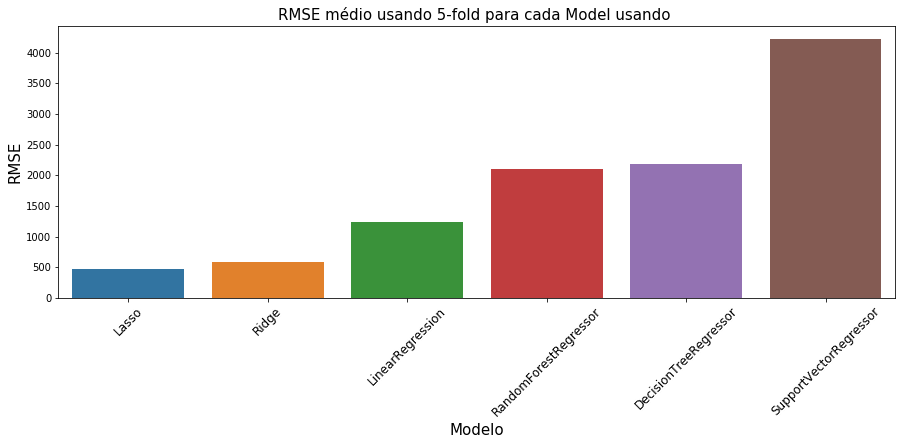

In [24]:
# Desenha um gráfico de barras
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'RMSE', data = df_results)
plt.title(f'RMSE médio usando {k}-fold para cada Model usando ', fontsize = 15)

plt.xlabel('Modelo', fontsize=15)
plt.ylabel('RMSE',fontsize=15)
plt.xticks(rotation=45, fontsize=12)
plt.show()

Para RMSE, quanto menor o valor, melhor é o modelo.

Assim, o melhor modelo foi o Lasso.

# 4. Prevendo resultados do Melhor Modelo Usando o Conjunto de Teste

Agora que já temos o melhor modelo para o nosso projeto, vamos realizar a previsão usando o conjunto de testes

In [25]:
#Pega o modelo com acurácia de validação média mais alta
best_model = df_results.iloc[0]

# Ajusta e faz uma previsão usando o modelo
model = models[best_model[0]]['model']
model.fit(X_train,y_train)
pred = model.predict(X_test)

# Calcula a acurácia de validação RMSE
RMSE = mean_squared_error(y_test,pred)**0.5
RMSE = int(RMSE)
Precision = r2_score(pred,y_test)

# Imprime o resultado da acurácia
print(f'Best Model: {best_model[0]}')
print(f'RMSE of {RMSE}')
print(f'Precisão: {Precision}')

Best Model: Lasso
RMSE of 1631
Precisão: 0.9878889714488154


Nosso modelo possui uma precisão de 98% !

## 5. Prevendo a Produção e Café

Após todas essas etapas, podemos comparar os valores totais de produção de café reais (usados como y_test) e os valores previstos pelo modelo (pred).

In [26]:
predict = pd.DataFrame()

predict['Produção Real'] = y_test
predict['Produção Prevista'] = pred

predict

,Produção Real,Produção Prevista
4,623.153000,815.599056
12,95.336500,83.313948
46,118.351467,99.035153
49,552.594300,1367.046991
48,36.521633,22.149753
5,10603.645367,10498.267484
18,208.056600,2770.036439
55,127.218300,105.855234
44,2560.954333,2393.972010
2,57484.308500,52836.811332


## Conclusão

Conseguimos criar um modelo de regressão que prevê a produção total de café com uma precisão de 98%.
